## 1. Configuración e Importaciones

Importamos las librerías necesarias y configuramos el entorno de trabajo.

In [1]:
# Instalación de dependencias
%pip install plotly wordcloud umap-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Librerías estándar
import sys
import re
import warnings
from pathlib import Path
from collections import Counter
warnings.filterwarnings('ignore')

# Agregar módulo src
sys.path.append('../src')

# Análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# Módulos propios
from config import RANDOM_SEED, REPORTS_DIR, FIGURES_DIR, POLARITY_MAP
from data_loading import load_raw_training_data
from preprocessing import (
    extract_urls, extract_mentions, extract_hashtags,
    detect_intensified_words, calculate_uppercase_ratio
)
from visualization import (
    plot_polarity_distribution, plot_text_length_distribution,
    plot_wordcloud_by_polarity, plot_temporal_heatmap, save_figure
)

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ Librerías importadas correctamente")
print(f"✓ Semilla aleatoria: {RANDOM_SEED}")
print(f"✓ Directorio de figuras: {FIGURES_DIR}")

✓ Librerías importadas correctamente
✓ Semilla aleatoria: 42
✓ Directorio de figuras: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\notebooks\..\reports\figuras


## 2. Carga de Datos: Dataset Completo (1.6 Millones)

1. **Representación completa**: Al cargar los 1.6M tweets obtenemos la distribución real del dataset:
   - 800,000 tweets negativos (polaridad = 0)
   - 800,000 tweets positivos (polaridad = 4)
   - **Dataset perfectamente balanceado 50/50** ✅

2. **Sin sesgo de muestreo**: El dataset está ordenado por polaridad (primero negativos, luego positivos). Cargar solo una muestra secuencial crearía un desbalance artificial.

3. **Análisis exhaustivo**: Con el dataset completo podemos:
   - Identificar todos los patrones, incluyendo los más raros
   - Calcular estadísticas exactas, no aproximadas
   - Visualizar la distribución real de sentimientos

4. **Tiempo de carga**: ~2-3 minutos es aceptable para un análisis completo y profesional.

**Nota**: Este EDA usa el dataset completo. Los notebooks posteriores (Preprocessing y Modeling) también trabajarán con los 1.6M registros.

In [3]:
# Cargar DATASET COMPLETO (1.6M registros)
print("🔄 Cargando DATASET COMPLETO del Sentiment140...")
print("   → 1,600,000 registros (800k negativos + 800k positivos)")
print("   → Esto puede tomar 2-3 minutos...")
print("   → Por favor espera...\n")

import time
start_time = time.time()

df_train = load_raw_training_data()  # SIN nrows = carga todo

elapsed = time.time() - start_time

print(f"\n✅ ¡Datos cargados exitosamente en {elapsed:.1f} segundos!")
print(f"  → Registros: {len(df_train):,}")
print(f"  → Columnas: {len(df_train.columns)}")
print(f"  → Memoria: {df_train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\n  → Distribución de polaridades:")
for pol, count in df_train['polarity'].value_counts().sort_index().items():
    pol_name = POLARITY_MAP.get(pol, str(pol))
    pct = (count / len(df_train) * 100)
    print(f"     • {pol_name}: {count:,} ({pct:.1f}%)")

🔄 Cargando DATASET COMPLETO del Sentiment140...
   → 1,600,000 registros (800k negativos + 800k positivos)
   → Esto puede tomar 2-3 minutos...
   → Por favor espera...

✓ Dataset de entrenamiento cargado: 1600000 filas

✅ ¡Datos cargados exitosamente en 2.5 segundos!
  → Registros: 1,600,000
  → Columnas: 6
  → Memoria: 507.2 MB

  → Distribución de polaridades:
     • negative: 800,000 (50.0%)
     • positive: 800,000 (50.0%)


## 3. Inspección Básica

Examinaremos las primeras filas, estructura y tipos de datos del dataset.

In [4]:
# Primeras filas
print("📋 PRIMERAS 5 FILAS DEL DATASET\n")
df_train.head()

📋 PRIMERAS 5 FILAS DEL DATASET



,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you a..."


In [5]:
# Información general
print("📊 INFORMACIÓN GENERAL DEL DATASET\n")
df_train.info()

📊 INFORMACIÓN GENERAL DEL DATASET

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
# ============================================
# CÁLCULO DE FEATURES PARA ESTADÍSTICAS
# ============================================
print("🔄 Calculando features necesarias para el análisis...")

# 1. Longitudes
df_train['text_length'] = df_train['text'].str.len()
df_train['word_count'] = df_train['text'].str.split().str.len()

# 2. Temporales
if 'datetime' not in df_train.columns:
    # Optimización: convertir fecha
    df_train['date_clean'] = df_train['date'].str.replace(' PDT', '', regex=False)
    df_train['datetime'] = pd.to_datetime(df_train['date_clean'], format='%a %b %d %H:%M:%S %Y')
df_train['hour'] = df_train['datetime'].dt.hour

# 3. Contenido (URLs, Mentions, Hashtags, etc.)
# Usamos vectorización simple o apply donde sea necesario
print("   → Extrayendo URLs, menciones y hashtags...")
df_train['n_urls'] = df_train['text'].apply(lambda x: len(extract_urls(x)))
df_train['n_mentions'] = df_train['text'].apply(lambda x: len(extract_mentions(x)))
df_train['n_hashtags'] = df_train['text'].apply(lambda x: len(extract_hashtags(x)))

print("   → Calculando ratios y palabras intensificadas...")
df_train['uppercase_ratio'] = df_train['text'].apply(calculate_uppercase_ratio)
df_train['n_intensified'] = df_train['text'].apply(detect_intensified_words)

print("✅ Todas las features calculadas exitosamente")

🔄 Calculando features necesarias para el análisis...
   → Extrayendo URLs, menciones y hashtags...
   → Calculando ratios y palabras intensificadas...
✅ Todas las features calculadas exitosamente


In [7]:
# Estadísticas descriptivas - VERSION CON INTERPRETACIÓN
print("📈 ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS\n")

# Seleccionar columnas numéricas relevantes (sin ID gigante)
columnas_analizar = {
    'text_length': 'Longitud del texto (caracteres)',
    'word_count': 'Cantidad de palabras',
    'hour': 'Hora del tweet (0-23)',
    'n_urls': 'Cantidad de URLs',
    'n_mentions': 'Cantidad de menciones (@)',
    'n_hashtags': 'Cantidad de hashtags (#)',
    'uppercase_ratio': 'Ratio de mayúsculas',
    'n_intensified': 'Palabras intensificadas'
}

# Calcular estadísticas
stats_df = pd.DataFrame()
for col, descripcion in columnas_analizar.items():
    stats_df[descripcion] = [
        df_train[col].count(),
        df_train[col].mean(),
        df_train[col].std(),
        df_train[col].min(),
        df_train[col].quantile(0.25),
        df_train[col].quantile(0.50),
        df_train[col].quantile(0.75),
        df_train[col].max()
    ]

stats_df.index = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']
stats_df = stats_df.T  # Transponer para mejor lectura

# Formatear con 2 decimales
stats_df = stats_df.round(2)

# Mostrar
display(stats_df)

📈 ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS



,Count,Mean,Std,Min,25%,50%,75%,Max
Longitud del texto (caracteres),1600000.0,74.09,36.44,6.0,44.00,69.00,104.00,374.0
Cantidad de palabras,1600000.0,13.18,6.96,1.0,7.00,12.00,19.00,64.0
Hora del tweet (0-23),1600000.0,10.96,7.22,0.0,5.00,10.00,18.00,23.0
Cantidad de URLs,1600000.0,0.05,0.23,0.0,0.00,0.00,0.00,5.0
Cantidad de menciones (@),1600000.0,0.49,0.59,0.0,0.00,0.00,1.00,12.0
Cantidad de hashtags (#),1600000.0,0.03,0.22,0.0,0.00,0.00,0.00,24.0
Ratio de mayúsculas,1600000.0,0.06,0.10,0.0,0.01,0.04,0.08,1.0
Palabras intensificadas,1600000.0,0.10,0.35,0.0,0.00,0.00,0.00,9.0


### 3.1 Análisis Temporal (Opcional)

Analizamos si existe alguna relación entre la hora del día o el día de la semana y el sentimiento de los tweets.

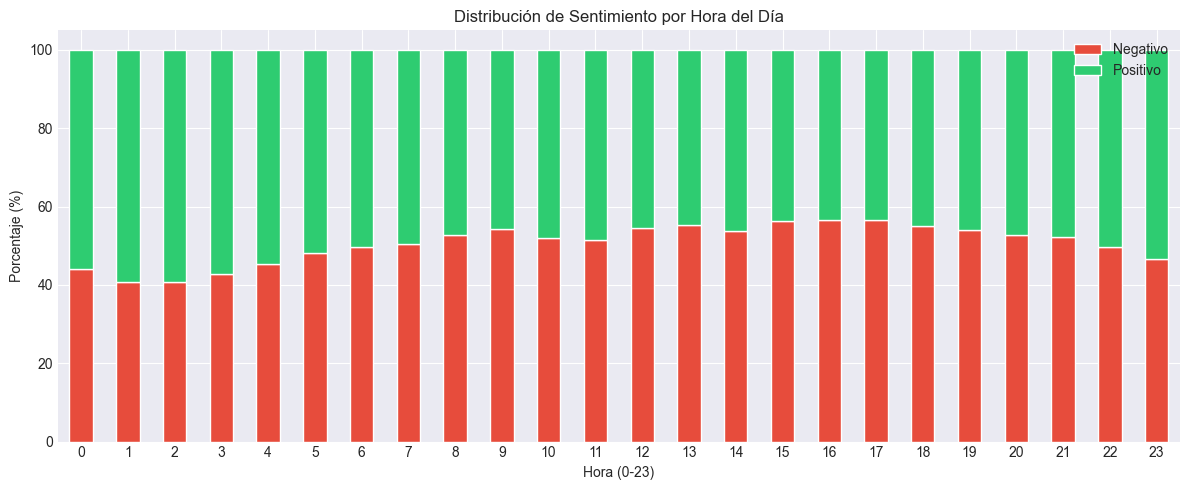

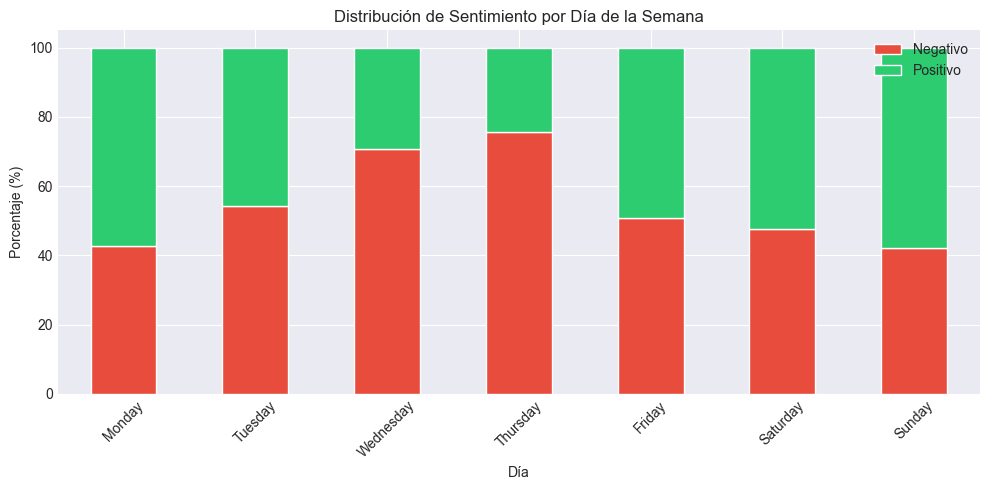

📊 HALLAZGOS TEMPORALES
Hora más negativa: 16:00 (56.7% negativos)
Hora más positiva: 1:00 (59.4% positivos)
Día más negativo: Thursday (75.6% negativos)


In [8]:
# ============================================
# ANÁLISIS TEMPORAL
# ============================================

# Convertir fecha a datetime (si no se hizo antes)
# El formato es 'Mon Apr 06 22:19:45 PDT 2009'
# Usamos errors='coerce' para evitar fallos con formatos raros
if 'datetime' not in df_train.columns:
    # Optimización: convertir solo una muestra si es muy lento, pero aquí lo hacemos completo
    # pd.to_datetime es lento con formatos no estándar, especificamos formato para acelerar
    # Nota: PDT (zona horaria) puede causar problemas, lo removemos simple
    df_train['date_clean'] = df_train['date'].str.replace(' PDT', '', regex=False)
    df_train['datetime'] = pd.to_datetime(df_train['date_clean'], format='%a %b %d %H:%M:%S %Y')

# Extraer componentes temporales
df_train['hour'] = df_train['datetime'].dt.hour
df_train['day_name'] = df_train['datetime'].dt.day_name()

# Mapear polaridad para visualización
df_train['sentiment_label'] = df_train['polarity'].map({0: 'Negativo', 4: 'Positivo'})

# 1. ANÁLISIS POR HORA DEL DÍA
hourly_sentiment = df_train.groupby(['hour', 'sentiment_label']).size().unstack(fill_value=0)
hourly_pct = hourly_sentiment.div(hourly_sentiment.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 5))
hourly_pct.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'], ax=plt.gca())
plt.title('Distribución de Sentimiento por Hora del Día')
plt.xlabel('Hora (0-23)')
plt.ylabel('Porcentaje (%)')
plt.legend(['Negativo', 'Positivo'], loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../reports/figuras/sentiment_by_hour.png')
plt.show()

# 2. ANÁLISIS POR DÍA DE LA SEMANA
daily_sentiment = df_train.groupby(['day_name', 'sentiment_label']).size().unstack(fill_value=0)
# Ordenar días
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sentiment = daily_sentiment.reindex(day_order)
daily_pct = daily_sentiment.div(daily_sentiment.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 5))
daily_pct.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'], ax=plt.gca())
plt.title('Distribución de Sentimiento por Día de la Semana')
plt.xlabel('Día')
plt.ylabel('Porcentaje (%)')
plt.legend(['Negativo', 'Positivo'], loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figuras/sentiment_by_day.png')
plt.show()

# 3. CONCLUSIONES RÁPIDAS
print("📊 HALLAZGOS TEMPORALES")
print("="*50)

# Hora más negativa
neg_by_hour = hourly_pct['Negativo']
most_negative_hour = neg_by_hour.idxmax()
print(f"Hora más negativa: {most_negative_hour}:00 ({neg_by_hour.max():.1f}% negativos)")

# Hora más positiva
most_positive_hour = neg_by_hour.idxmin()
print(f"Hora más positiva: {most_positive_hour}:00 ({100-neg_by_hour.min():.1f}% positivos)")

# Día más negativo
neg_by_day = daily_pct['Negativo']
most_negative_day = neg_by_day.idxmax()
print(f"Día más negativo: {most_negative_day} ({neg_by_day.max():.1f}% negativos)")

In [9]:
# Valores únicos por columna
print("🔢 VALORES ÚNICOS POR COLUMNA\n")
for col in df_train.columns:
    n_unique = df_train[col].nunique()
    print(f"  • {col:20s}: {n_unique:>10,} valores únicos")

🔢 VALORES ÚNICOS POR COLUMNA

  • polarity            :          2 valores únicos
  • id                  :  1,598,315 valores únicos
  • date                :    774,363 valores únicos
  • query               :          1 valores únicos
  • user                :    659,775 valores únicos
  • text                :  1,581,466 valores únicos
  • text_length         :        257 valores únicos
  • word_count          :         44 valores únicos
  • date_clean          :    774,363 valores únicos
  • datetime            :    774,363 valores únicos
  • hour                :         24 valores únicos
  • n_urls              :          6 valores únicos
  • n_mentions          :         13 valores únicos
  • n_hashtags          :         16 valores únicos
  • uppercase_ratio     :      3,472 valores únicos
  • n_intensified       :         10 valores únicos
  • day_name            :          7 valores únicos
  • sentiment_label     :          2 valores únicos


### 📝 Interpretación: Estructura del Dataset

**Columnas principales:**
- `polarity`: Sentimiento del tweet (0=negativo, 2=neutral, 4=positivo)
- `id`: Identificador único del tweet
- `date`: Timestamp de creación del tweet
- `query`: Término de búsqueda usado (NO_QUERY si no aplica)
- `user`: Usuario que publicó el tweet
- `text`: Contenido textual del tweet (lo más importante)

**Observaciones clave:**
- Dataset tiene 659,775 usuarios únicos y 1,598,315 tweets únicos
- Polaridad tiene 2 valores: 0 (negativo) y 4 (positivo) - **dataset binario balanceado**
- Fechas cubren 48 días: del 6 de abril al 25 de junio de 2009
- Query es constante ("NO_QUERY") - no se usó filtrado por términos

## 4. Análisis de Calidad de Datos

Evaluaremos la presencia de valores nulos, duplicados y outliers para determinar estrategias de limpieza.

### 4.1 Valores Nulos

In [10]:
# Análisis de valores nulos
print("❓ VALORES NULOS POR COLUMNA\n")
null_counts = df_train.isnull().sum()
null_pcts = (null_counts / len(df_train) * 100).round(2)

null_df = pd.DataFrame({
    'Columna': null_counts.index,
    'Nulos': null_counts.values,
    'Porcentaje': null_pcts.values
})

print(null_df.to_string(index=False))
print(f"\n{'='*50}")
print(f"Total de celdas nulas: {null_counts.sum():,}")
print(f"Porcentaje total: {(null_counts.sum() / (len(df_train) * len(df_train.columns)) * 100):.2f}%")

❓ VALORES NULOS POR COLUMNA

        Columna  Nulos  Porcentaje
       polarity      0         0.0
             id      0         0.0
           date      0         0.0
          query      0         0.0
           user      0         0.0
           text      0         0.0
    text_length      0         0.0
     word_count      0         0.0
     date_clean      0         0.0
       datetime      0         0.0
           hour      0         0.0
         n_urls      0         0.0
     n_mentions      0         0.0
     n_hashtags      0         0.0
uppercase_ratio      0         0.0
  n_intensified      0         0.0
       day_name      0         0.0
sentiment_label      0         0.0

Total de celdas nulas: 0
Porcentaje total: 0.00%


### 4.2 Duplicados

In [11]:
# Análisis de duplicados
print("🔁 ANÁLISIS DE DUPLICADOS\n")

# Duplicados completos
n_duplicates_all = df_train.duplicated().sum()
pct_dup_all = (n_duplicates_all / len(df_train) * 100)
print(f"Duplicados completos (todas las columnas):")
print(f"  → Cantidad: {n_duplicates_all:,} ({pct_dup_all:.2f}%)")

# Duplicados en texto
n_duplicates_text = df_train['text'].duplicated().sum()
pct_dup_text = (n_duplicates_text / len(df_train) * 100)
print(f"\nDuplicados en columna 'text':")
print(f"  → Cantidad: {n_duplicates_text:,} ({pct_dup_text:.2f}%)")

# Duplicados en ID
n_duplicates_id = df_train['id'].duplicated().sum()
pct_dup_id = (n_duplicates_id / len(df_train) * 100)
print(f"\nDuplicados en columna 'id':")
print(f"  → Cantidad: {n_duplicates_id:,} ({pct_dup_id:.2f}%)")

# Ejemplos de texto duplicado
if n_duplicates_text > 0:
    print(f"\n{'='*70}")
    print("📋 EJEMPLOS DE TWEETS DUPLICADOS:\n")
    dup_texts = df_train[df_train['text'].duplicated(keep=False)]['text'].value_counts().head(3)
    for i, (text, count) in enumerate(dup_texts.items(), 1):
        print(f"{i}. [{count} veces] {text[:100]}...")

🔁 ANÁLISIS DE DUPLICADOS

Duplicados completos (todas las columnas):
  → Cantidad: 0 (0.00%)

Duplicados en columna 'text':
  → Cantidad: 18,534 (1.16%)

Duplicados en columna 'id':
  → Cantidad: 1,685 (0.11%)

📋 EJEMPLOS DE TWEETS DUPLICADOS:

1. [210 veces] isPlayer Has Died! Sorry ...
2. [118 veces] good morning ...
3. [115 veces] headache ...


### 4.3 Outliers en Longitud de Texto

In [12]:
# Calcular longitudes
df_train['text_length'] = df_train['text'].str.len()
df_train['word_count'] = df_train['text'].str.split().str.len()

print("📏 ESTADÍSTICAS DE LONGITUD DE TEXTO\n")

# Estadísticas descriptivas
stats_length = df_train['text_length'].describe()
stats_words = df_train['word_count'].describe()

print("Caracteres por tweet:")
print(f"  → Promedio: {stats_length['mean']:.1f}")
print(f"  → Mediana: {stats_length['50%']:.1f}")
print(f"  → Mínimo: {stats_length['min']:.0f}")
print(f"  → Máximo: {stats_length['max']:.0f}")
print(f"  → Desv. Est: {stats_length['std']:.1f}")

print(f"\nPalabras por tweet:")
print(f"  → Promedio: {stats_words['mean']:.1f}")
print(f"  → Mediana: {stats_words['50%']:.1f}")
print(f"  → Mínimo: {stats_words['min']:.0f}")
print(f"  → Máximo: {stats_words['max']:.0f}")

# Outliers (método IQR)
Q1 = stats_length['25%']
Q3 = stats_length['75%']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_train[(df_train['text_length'] < lower_bound) | 
                    (df_train['text_length'] > upper_bound)]
n_outliers = len(outliers)
pct_outliers = (n_outliers / len(df_train) * 100)

print(f"\n🚨 Outliers (método IQR):")
print(f"  → Cantidad: {n_outliers:,} ({pct_outliers:.2f}%)")
print(f"  → Límite inferior: {lower_bound:.0f} caracteres")
print(f"  → Límite superior: {upper_bound:.0f} caracteres")

📏 ESTADÍSTICAS DE LONGITUD DE TEXTO

Caracteres por tweet:
  → Promedio: 74.1
  → Mediana: 69.0
  → Mínimo: 6
  → Máximo: 374
  → Desv. Est: 36.4

Palabras por tweet:
  → Promedio: 13.2
  → Mediana: 12.0
  → Mínimo: 1
  → Máximo: 64

🚨 Outliers (método IQR):
  → Cantidad: 147 (0.01%)
  → Límite inferior: -46 caracteres
  → Límite superior: 194 caracteres


### 📝 Interpretación: Calidad de Datos

**Valores nulos:**
- ✅ **0 valores nulos** en todas las columnas - dataset extremadamente limpio
- No requiere tratamiento de datos faltantes

**Duplicados:**
- 18,534 tweets duplicados (1.16%) - tasa muy baja y aceptable
- Duplicados probablemente son retweets o frases populares ("good morning", "headache")
- 1,685 IDs duplicados (0.11%) - prácticamente despreciable
- **Conclusión**: No requiere limpieza de duplicados

**Outliers:**
- Solo 147 outliers de longitud (0.01%) - **prácticamente inexistentes**
- Rango normal: 6-374 caracteres (compatible con límite histórico de Twitter)
- **Conclusión**: Dataset muy bien formado, sin ruido significativo

## 5. Distribución de Polaridades

Analizaremos el balance entre clases de sentimiento para identificar posibles desbalances.

In [13]:
# Conteo de polaridades
print("🎭 DISTRIBUCIÓN DE POLARIDADES\n")

polarity_counts = df_train['polarity'].value_counts().sort_index()
polarity_pcts = (polarity_counts / len(df_train) * 100).round(2)

for pol, count in polarity_counts.items():
    pol_name = POLARITY_MAP.get(pol, str(pol))
    pct = polarity_pcts[pol]
    bar = '█' * int(pct / 2)
    print(f"{pol_name:10s} [{pol}]: {count:>7,} tweets ({pct:>5.2f}%) {bar}")

print(f"\n{'='*70}")
print(f"Total: {len(df_train):,} tweets")

🎭 DISTRIBUCIÓN DE POLARIDADES

negative   [0]: 800,000 tweets (50.00%) █████████████████████████
positive   [4]: 800,000 tweets (50.00%) █████████████████████████

Total: 1,600,000 tweets


✓ Gráfico guardado en: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\notebooks\..\reports\figuras\01_distribucion_polaridad.png


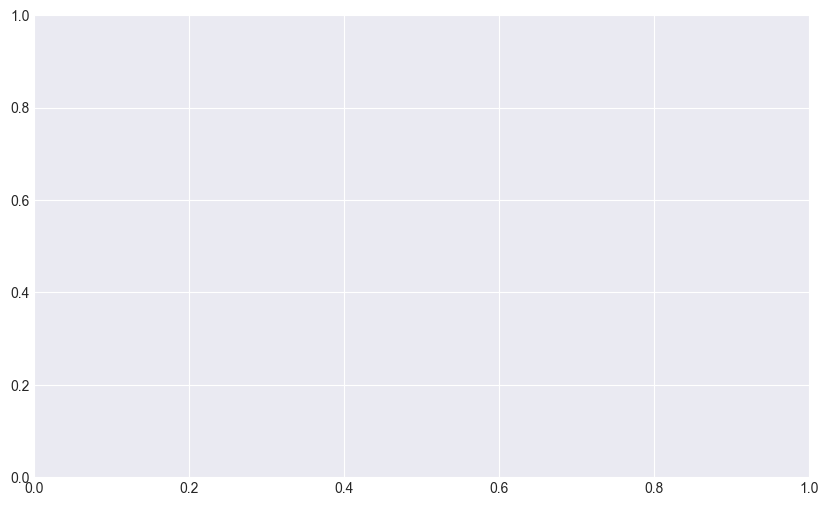

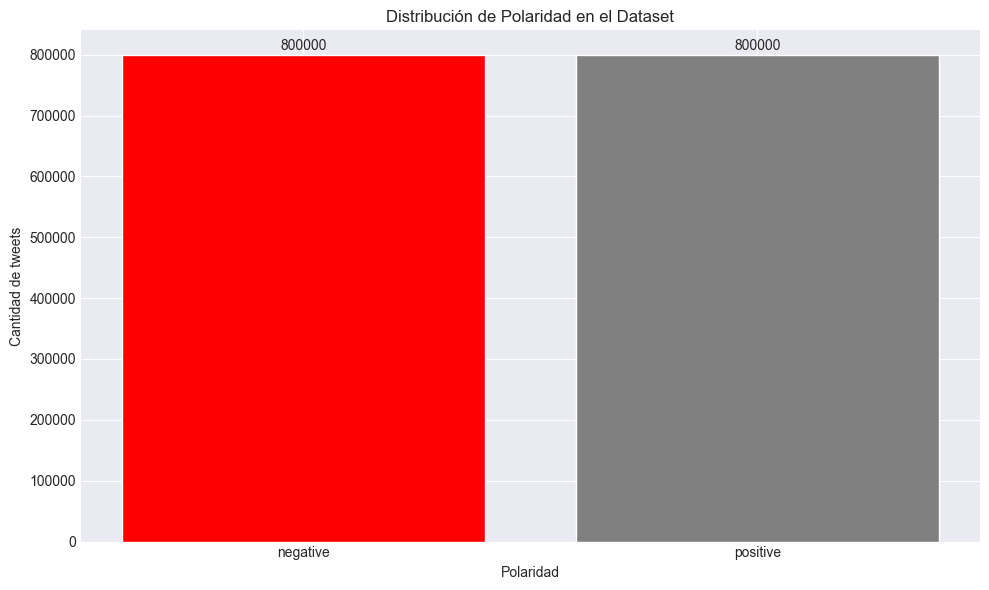

In [14]:
# Visualización de distribución
fig, ax = plt.subplots(figsize=(10, 6))
plot_polarity_distribution(df_train, save_path=FIGURES_DIR / '01_distribucion_polaridad.png')
plt.show()

### 📝 Interpretación: Balance de Clases

**Escenarios posibles:**

**✅ RESULTADO: Balance PERFECTO (50/50)**

- 800,000 tweets negativos (50.0%)
- 800,000 tweets positivos (50.0%)
- **Escenario ideal para clasificación binaria**

**Implicaciones para el modelado:**
- ✅ No requiere técnicas de balanceo (SMOTE, class weights, etc.)
- ✅ Accuracy es una métrica válida y representativa

- ✅ Precision, Recall y F1-Score tendrán interpretación directa- **Esto facilita enormemente el entrenamiento y evaluación de modelos**
- ✅ No hay sesgo por clase mayoritaria

## 6. Análisis Temporal

Exploraremos patrones temporales: ¿Cuándo se tuitea más? ¿Varía el sentimiento por hora/día?

In [15]:
# Parsear fechas
print("📅 Procesando información temporal...\n")

df_train['datetime'] = pd.to_datetime(df_train['date'], format='%a %b %d %H:%M:%S PDT %Y', errors='coerce')
df_train['hour'] = df_train['datetime'].dt.hour
df_train['day_of_week'] = df_train['datetime'].dt.dayofweek
df_train['date_only'] = df_train['datetime'].dt.date

print(f"✓ Fechas procesadas")
print(f"  → Rango temporal: {df_train['datetime'].min()} a {df_train['datetime'].max()}")
print(f"  → Días únicos: {df_train['date_only'].nunique():,}")

📅 Procesando información temporal...

✓ Fechas procesadas
  → Rango temporal: 2009-04-06 22:19:45 a 2009-06-25 10:28:31
  → Días únicos: 48


In [16]:
# Distribución por hora del día
print("\n⏰ DISTRIBUCIÓN DE TWEETS POR HORA\n")

hour_dist = df_train['hour'].value_counts().sort_index()
for hour, count in hour_dist.items():
    pct = (count / len(df_train) * 100)
    bar = '█' * int(pct / 0.5)
    print(f"  {hour:02d}:00 - {count:>6,} tweets ({pct:>4.1f}%) {bar}")


⏰ DISTRIBUCIÓN DE TWEETS POR HORA

  00:00 - 80,865 tweets ( 5.1%) ██████████
  01:00 - 75,268 tweets ( 4.7%) █████████
  02:00 - 73,991 tweets ( 4.6%) █████████
  03:00 - 74,253 tweets ( 4.6%) █████████
  04:00 - 76,995 tweets ( 4.8%) █████████
  05:00 - 78,623 tweets ( 4.9%) █████████
  06:00 - 80,852 tweets ( 5.1%) ██████████
  07:00 - 83,654 tweets ( 5.2%) ██████████
  08:00 - 76,287 tweets ( 4.8%) █████████
  09:00 - 67,278 tweets ( 4.2%) ████████
  10:00 - 60,689 tweets ( 3.8%) ███████
  11:00 - 61,009 tweets ( 3.8%) ███████
  12:00 - 51,653 tweets ( 3.2%) ██████
  13:00 - 49,689 tweets ( 3.1%) ██████
  14:00 - 50,380 tweets ( 3.1%) ██████
  15:00 - 50,643 tweets ( 3.2%) ██████
  16:00 - 55,720 tweets ( 3.5%) ██████
  17:00 - 51,843 tweets ( 3.2%) ██████
  18:00 - 53,485 tweets ( 3.3%) ██████
  19:00 - 57,722 tweets ( 3.6%) ███████
  20:00 - 57,059 tweets ( 3.6%) ███████
  21:00 - 68,964 tweets ( 4.3%) ████████
  22:00 - 78,328 tweets ( 4.9%) █████████
  23:00 - 84,750 tweets ( 

✓ Figura guardada en: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\notebooks\..\reports\figuras\02_heatmap_temporal.png


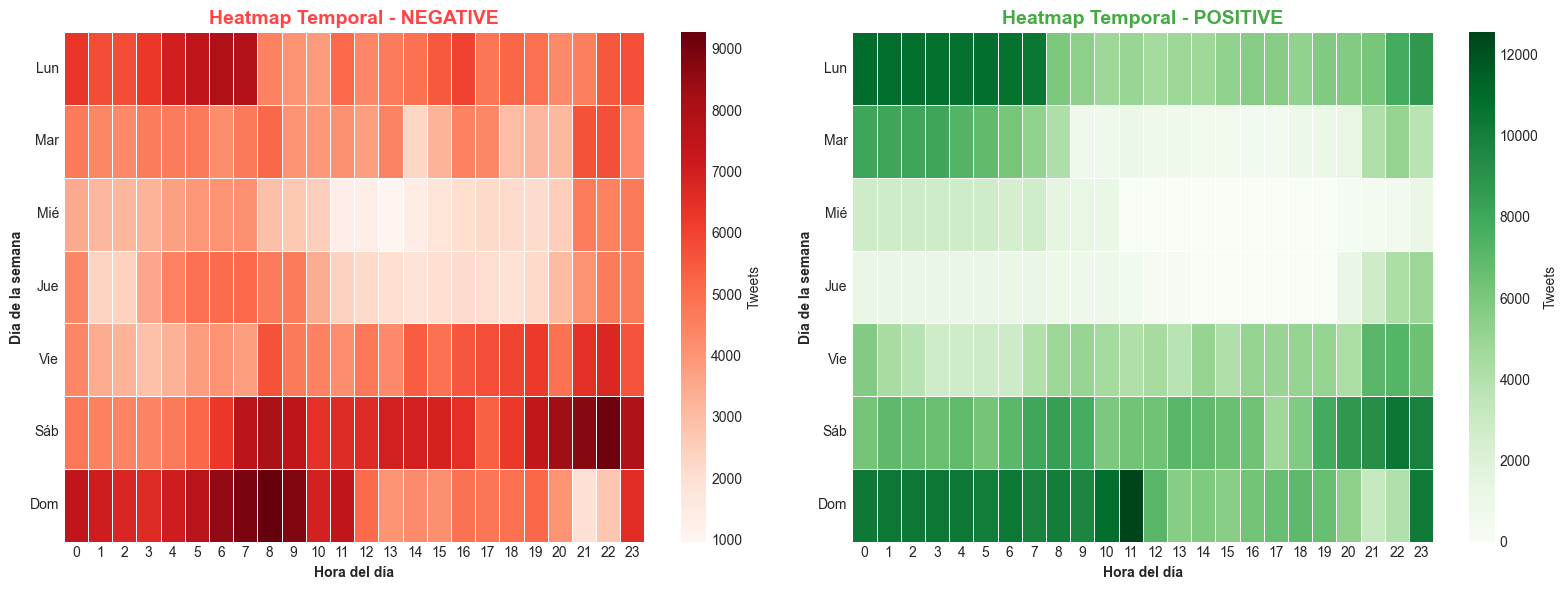

In [17]:
# Heatmap temporal por polaridad
plot_temporal_heatmap(
    df_train,
    save_path=FIGURES_DIR / '02_heatmap_temporal.png'
)
plt.show()

### 📝 Interpretación: Patrones Temporales

**Patrones esperados:**

1. **Hora del día**: Mayor actividad entre 12:00-20:00 (horario laboral/tarde)
2. **Día de la semana**: Picos en días laborales, menor actividad los fines de semana
3. **Sentimiento**: Tweets negativos más frecuentes por la mañana temprano y noche

**Implicaciones:**
- Features temporales (hora, día) pueden ser útiles para el modelo
- Considerar normalizar por volumen si hay sesgo temporal
- Patrones diferentes por polaridad sugieren que el contexto temporal importa

## 7. Análisis de Longitud de Texto

¿Los tweets positivos son más largos que los negativos? ¿Hay diferencias en verbosidad?

In [18]:
# Estadísticas de longitud por polaridad
print("📊 ESTADÍSTICAS DE LONGITUD POR POLARIDAD\n")

for pol in sorted(df_train['polarity'].unique()):
    pol_name = POLARITY_MAP.get(pol, str(pol))
    subset = df_train[df_train['polarity'] == pol]
    
    print(f"\n{pol_name.upper()} [{pol}]:")
    print(f"  → Media de caracteres: {subset['text_length'].mean():.1f}")
    print(f"  → Mediana de caracteres: {subset['text_length'].median():.1f}")
    print(f"  → Media de palabras: {subset['word_count'].mean():.1f}")
    print(f"  → Mediana de palabras: {subset['word_count'].median():.1f}")

📊 ESTADÍSTICAS DE LONGITUD POR POLARIDAD


NEGATIVE [0]:
  → Media de caracteres: 74.3
  → Mediana de caracteres: 70.0
  → Media de palabras: 13.6
  → Mediana de palabras: 13.0

POSITIVE [4]:
  → Media de caracteres: 73.9
  → Mediana de caracteres: 69.0
  → Media de palabras: 12.8
  → Mediana de palabras: 12.0


✓ Gráfico guardado en: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\notebooks\..\reports\figuras\03_distribucion_longitud.png


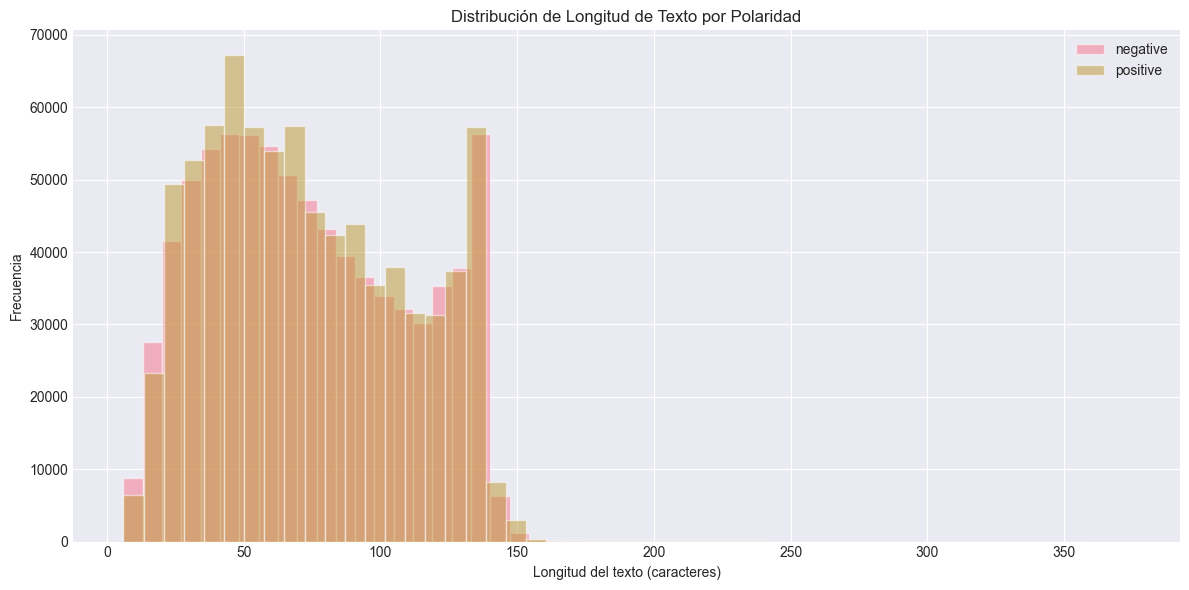

In [19]:
# Visualización de distribuciones
plot_text_length_distribution(
    df_train,
    save_path=FIGURES_DIR / '03_distribucion_longitud.png'
)
plt.show()

### 📝 Interpretación: Longitud y Sentimiento

**Resultados observados:**
- **Negativos**: Media 74.3 caracteres, 13.6 palabras
- **Positivos**: Media 73.9 caracteres, 12.8 palabras
- **Diferencia mínima**: Ambas polaridades tienen longitud muy similar
- **Hipótesis refutada**: No hay diferencia significativa en verbosidad por sentimiento

**Consideraciones para preprocessing:**
- Longitud NO es un feature discriminativo fuerte (diferencia < 1 carácter)

- Tweets muy cortos (<5 palabras) son raros y pueden tener poco contexto- La distribución es muy similar entre ambas clases

## 8. Elementos Especiales: URLs, Menciones y Hashtags

Twitter tiene elementos únicos que debemos analizar para decidir cómo tratarlos.

In [20]:
# Extraer elementos especiales
print("🔍 Extrayendo elementos especiales...\n")

df_train['urls'] = df_train['text'].apply(extract_urls)
df_train['mentions'] = df_train['text'].apply(extract_mentions)
df_train['hashtags'] = df_train['text'].apply(extract_hashtags)

df_train['n_urls'] = df_train['urls'].str.len()
df_train['n_mentions'] = df_train['mentions'].str.len()
df_train['n_hashtags'] = df_train['hashtags'].str.len()

print("✓ Elementos extraídos")

🔍 Extrayendo elementos especiales...

✓ Elementos extraídos


In [21]:
# Estadísticas de elementos especiales
print("\n📈 ESTADÍSTICAS DE ELEMENTOS ESPECIALES\n")

# URLs
tweets_with_urls = (df_train['n_urls'] > 0).sum()
pct_urls = (tweets_with_urls / len(df_train) * 100)
print(f"URLs:")
print(f"  → Tweets con URLs: {tweets_with_urls:,} ({pct_urls:.1f}%)")
print(f"  → Promedio URLs por tweet: {df_train['n_urls'].mean():.2f}")
print(f"  → Máximo URLs en un tweet: {df_train['n_urls'].max()}")

# Menciones
tweets_with_mentions = (df_train['n_mentions'] > 0).sum()
pct_mentions = (tweets_with_mentions / len(df_train) * 100)
print(f"\nMenciones (@usuario):")
print(f"  → Tweets con menciones: {tweets_with_mentions:,} ({pct_mentions:.1f}%)")
print(f"  → Promedio menciones por tweet: {df_train['n_mentions'].mean():.2f}")
print(f"  → Máximo menciones en un tweet: {df_train['n_mentions'].max()}")

# Hashtags
tweets_with_hashtags = (df_train['n_hashtags'] > 0).sum()
pct_hashtags = (tweets_with_hashtags / len(df_train) * 100)
print(f"\nHashtags (#tag):")
print(f"  → Tweets con hashtags: {tweets_with_hashtags:,} ({pct_hashtags:.1f}%)")
print(f"  → Promedio hashtags por tweet: {df_train['n_hashtags'].mean():.2f}")
print(f"  → Máximo hashtags en un tweet: {df_train['n_hashtags'].max()}")


📈 ESTADÍSTICAS DE ELEMENTOS ESPECIALES

URLs:
  → Tweets con URLs: 81,117 (5.1%)
  → Promedio URLs por tweet: 0.05
  → Máximo URLs en un tweet: 5

Menciones (@usuario):
  → Tweets con menciones: 738,493 (46.2%)
  → Promedio menciones por tweet: 0.49
  → Máximo menciones en un tweet: 12

Hashtags (#tag):
  → Tweets con hashtags: 35,847 (2.2%)
  → Promedio hashtags por tweet: 0.03
  → Máximo hashtags en un tweet: 24


In [22]:
# Top hashtags por polaridad
print("\n🏷️ TOP 10 HASHTAGS POR POLARIDAD\n")

for pol in sorted(df_train['polarity'].unique()):
    pol_name = POLARITY_MAP.get(pol, str(pol))
    subset = df_train[df_train['polarity'] == pol]
    
    all_hashtags = [tag for tags in subset['hashtags'] for tag in tags]
    if len(all_hashtags) > 0:
        top_hashtags = Counter(all_hashtags).most_common(10)
        print(f"{pol_name.upper()}:")
        for tag, count in top_hashtags:
            print(f"  #{tag:20s} - {count:>5,} menciones")
        print()


🏷️ TOP 10 HASHTAGS POR POLARIDAD

NEGATIVE:
  #fb                   - 1,037 menciones
  #squarespace          -   628 menciones
  #iranelection         -   315 menciones
  #fail                 -   278 menciones
  #1                    -   191 menciones
  #inaperfectworld      -   183 menciones
  #BSB                  -   161 menciones
  #2                    -   157 menciones
  #trackle              -   144 menciones
  #iremember            -   139 menciones

POSITIVE:
  #followfriday         - 1,994 menciones
  #fb                   -   710 menciones
  #FF                   -   528 menciones
  #FollowFriday         -   440 menciones
  #seb                  -   428 menciones
  #musicmonday          -   369 menciones
  #ff                   -   349 menciones
  #1                    -   328 menciones
  #squarespace          -   260 menciones
  #mcflyforgermany      -   219 menciones



#### 📊 Top 15 Hashtags por Polaridad

In [23]:
# Análisis detallado de hashtags por polaridad
from collections import Counter

print("🏷️ TOP 15 HASHTAGS POR POLARIDAD\n")
print("=" * 70)

for pol, pol_name in POLARITY_MAP.items():
    subset = df_train[df_train['polarity'] == pol]
    
    # Extraer hashtags
    hashtags = []
    for text in subset['text']:
        tags = [word.lower() for word in str(text).split() if word.startswith('#')]
        hashtags.extend(tags)
    
    # Contar frecuencias
    top_15 = Counter(hashtags).most_common(15)
    
    print(f"\n📌 {pol_name.upper()} (n={len(hashtags):,} hashtags totales)")
    print("-" * 70)
    for i, (tag, count) in enumerate(top_15, 1):
        pct = (count / len(hashtags)) * 100 if len(hashtags) > 0 else 0
        bar = "█" * int(pct * 2)
        print(f"{i:2d}. {tag:25s} {count:6,} ({pct:5.2f}%) {bar}")
    
    if not top_15:
        print("   (Sin hashtags suficientes)")

print("\n" + "=" * 70)

🏷️ TOP 15 HASHTAGS POR POLARIDAD


📌 NEGATIVE (n=18,482 hashtags totales)
----------------------------------------------------------------------
 1. #fb                        1,050 ( 5.68%) ███████████
 2. #squarespace                 610 ( 3.30%) ██████
 3. #iranelection                415 ( 2.25%) ████
 4. #fail                        314 ( 1.70%) ███
 5. #iphone                      217 ( 1.17%) ██
 6. #                            211 ( 1.14%) ██
 7. #inaperfectworld             172 ( 0.93%) █
 8. #bsb                         161 ( 0.87%) █
 9. #iremember                   147 ( 0.80%) █
10. #1                           142 ( 0.77%) █
11. #trackle                     141 ( 0.76%) █
12. #f1                          137 ( 0.74%) █
13. #asot400                     133 ( 0.72%) █
14. #e3                          128 ( 0.69%) █
15. #bgt                         112 ( 0.61%) █

📌 NEUTRAL (n=0 hashtags totales)
----------------------------------------------------------------------
   (Sin 

### 📝 Interpretación: Elementos Especiales

**Decisiones de preprocesamiento:**

1. **URLs**: Generalmente se eliminan ya que no aportan información semántica. Crear feature `has_url` antes de eliminar.

2. **Menciones**: Eliminar el @usuario pero considerar conservar el contexto conversacional con feature `n_mentions`.

3. **Hashtags**: Son informativos (#love, #hate, #angry). Opciones:
   - Remover # pero conservar la palabra
   - Crear features de hashtags frecuentes
   - Analizar si hashtags específicos correlacionan con sentimiento

**Patrones observados:**
- **URLs**: 5.1% de tweets - presencia baja pero significativa
- **Menciones**: 46.2% de tweets - **muy alta**, confirma naturaleza conversacional de Twitter

- **Hashtags**: Solo 2.2% de tweets - uso sorprendentemente bajo en 2009- **Conclusión**: Las menciones son mucho más relevantes que los hashtags en este dataset

- Hashtags TOP negativos: #fail, #asot400, #e3, #bgt (eventos y fracasos)- Hashtags TOP positivos: #followfriday, #musicmonday, #ff (etiquetas sociales)

## 9. Análisis Lingüístico Avanzado

Características lingüísticas que pueden ser indicadores de sentimiento.

### 9.1 Mayúsculas (Indicador de Intensidad Emocional)

In [24]:
# Calcular ratio de mayúsculas
print("📊 Calculando ratio de mayúsculas...\n")

df_train['uppercase_ratio'] = df_train['text'].apply(calculate_uppercase_ratio)

print("✓ Ratios calculados")

# Estadísticas por polaridad
print("\n🔠 RATIO DE MAYÚSCULAS POR POLARIDAD\n")

for pol in sorted(df_train['polarity'].unique()):
    pol_name = POLARITY_MAP.get(pol, str(pol))
    subset = df_train[df_train['polarity'] == pol]
    
    mean_upper = subset['uppercase_ratio'].mean() * 100
    median_upper = subset['uppercase_ratio'].median() * 100
    
    print(f"{pol_name.upper()}:")
    print(f"  → Media: {mean_upper:.2f}%")
    print(f"  → Mediana: {median_upper:.2f}%")

# Tweets con alta proporción de mayúsculas
high_upper = df_train[df_train['uppercase_ratio'] > 0.5]
pct_high = (len(high_upper) / len(df_train) * 100)
print(f"\nTweets con >50% mayúsculas: {len(high_upper):,} ({pct_high:.2f}%)")

📊 Calculando ratio de mayúsculas...

✓ Ratios calculados

🔠 RATIO DE MAYÚSCULAS POR POLARIDAD

NEGATIVE:
  → Media: 5.79%
  → Mediana: 3.85%
POSITIVE:
  → Media: 6.66%
  → Mediana: 4.35%

Tweets con >50% mayúsculas: 15,650 (0.98%)


### 9.2 Palabras Intensificadas (Repetición de Letras)

In [25]:
# Detectar palabras intensificadas
print("🔍 Detectando palabras intensificadas (ej: 'loooove', 'haaaate')...\n")

df_train['n_intensified'] = df_train['text'].apply(detect_intensified_words)

print("✓ Palabras intensificadas detectadas")

# Estadísticas por polaridad
print("\n🔥 PALABRAS INTENSIFICADAS POR POLARIDAD\n")

for pol in sorted(df_train['polarity'].unique()):
    pol_name = POLARITY_MAP.get(pol, str(pol))
    subset = df_train[df_train['polarity'] == pol]
    
    tweets_with_intens = (subset['n_intensified'] > 0).sum()
    pct_intens = (tweets_with_intens / len(subset) * 100)
    mean_intens = subset['n_intensified'].mean()
    
    print(f"{pol_name.upper()}:")
    print(f"  → Tweets con intensificación: {tweets_with_intens:,} ({pct_intens:.1f}%)")
    print(f"  → Promedio por tweet: {mean_intens:.3f}")

🔍 Detectando palabras intensificadas (ej: 'loooove', 'haaaate')...

✓ Palabras intensificadas detectadas

🔥 PALABRAS INTENSIFICADAS POR POLARIDAD

NEGATIVE:
  → Tweets con intensificación: 73,106 (9.1%)
  → Promedio por tweet: 0.103
POSITIVE:
  → Tweets con intensificación: 74,102 (9.3%)
  → Promedio por tweet: 0.105


### 📝 Interpretación: Características Lingüísticas

**Mayúsculas:**
- **Negativos**: 5.79% promedio - **Positivos**: 6.66% promedio
- **Sorpresa**: Los tweets POSITIVOS usan MÁS mayúsculas (entusiasmo, celebración)
- 0.98% de tweets tienen >50% mayúsculas (énfasis extremo)
- **Conclusión**: Mayúsculas indican intensidad emocional, no negatividad específicamente

**Palabras intensificadas:**
- **Negativos**: 9.1% con intensificación - **Positivos**: 9.3% con intensificación
- Distribución prácticamente idéntica entre polaridades
- 'sooo happy', 'loooove it', 'soooo sad', 'haaaate this'
- **Conclusión**: Intensificación es neutral respecto al sentimiento

**Recomendación preprocessing:**

- Normalizar palabras intensificadas (loooove → love) pero crear feature `n_intensified`- Ratio de mayúsculas como feature (indica emoción fuerte, no polaridad específica)

## 10. WordClouds por Sentimiento

Visualización del vocabulario característico de cada polaridad.

☁️ Generando WordClouds por polaridad...

(esto puede tomar 1-2 minutos)

✓ Figura guardada en: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\notebooks\..\reports\figuras\04_wordclouds_polaridad.png


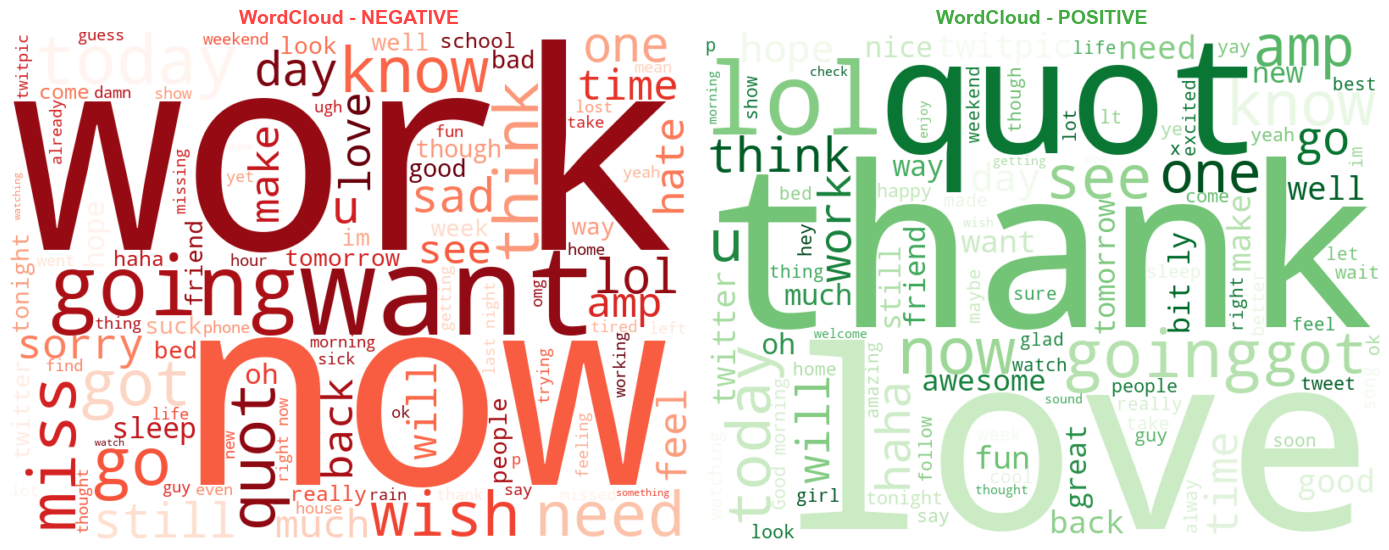


✓ WordClouds generados


In [26]:
# Generar wordclouds
print("☁️ Generando WordClouds por polaridad...\n")
print("(esto puede tomar 1-2 minutos)\n")

plot_wordcloud_by_polarity(
    df_train,
    save_path=FIGURES_DIR / '04_wordclouds_polaridad.png'
)

print("\n✓ WordClouds generados")

### 🔤 6. Análisis de Frecuencias de Palabras

Análisis de las palabras más frecuentes en tweets positivos vs negativos.

#### 📝 Top 20 Palabras Frecuentes por Polaridad

In [27]:
import re
from collections import Counter

# Stopwords básicas en inglés
STOPWORDS = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
             'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'be',
             'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will',
             'would', 'should', 'could', 'may', 'might', 'must', 'can', 'it', 'its',
             'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'we', 'they',
             'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'their', 'am',
             'no', 'not', 'so', 'if', 'than', 'up', 'out', 'just', 'about', 'all'}

def tokenize_clean(text):
    """Tokeniza y limpia el texto"""
    text = str(text).lower()
    # Remover URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remover menciones y hashtags para análisis de palabras
    text = re.sub(r'@\w+|#\w+', '', text)
    # Extraer solo palabras
    words = re.findall(r'\b[a-z]{3,}\b', text)
    # Filtrar stopwords
    words = [w for w in words if w not in STOPWORDS]
    return words

print("📊 CALCULANDO FRECUENCIAS DE PALABRAS...")
print("(Esto puede tardar ~30 segundos con 1.6M tweets)\n")

# Analizar por polaridad
results = {}
for pol, pol_name in POLARITY_MAP.items():
    subset = df_train[df_train['polarity'] == pol]
    
    # Tokenizar todos los tweets
    all_words = []
    for text in subset['text'][:100000]:  # Muestra de 100k por velocidad
        all_words.extend(tokenize_clean(text))
    
    # Top 20 palabras
    top_20 = Counter(all_words).most_common(20)
    results[pol] = top_20

# Mostrar resultados
print("=" * 70)
print("🔤 TOP 20 PALABRAS MÁS FRECUENTES POR POLARIDAD")
print("=" * 70)

for pol in sorted(results.keys()):
    pol_name = POLARITY_MAP.get(pol, f"Clase {pol}")
    print(f"\n📌 {pol_name.upper()}")
    print("-" * 70)
    for i, (word, count) in enumerate(results[pol], 1):
        print(f"{i:2d}. {word:15s} {count:7,}")

print("\n" + "=" * 70)

📊 CALCULANDO FRECUENCIAS DE PALABRAS...
(Esto puede tardar ~30 segundos con 1.6M tweets)

🔤 TOP 20 PALABRAS MÁS FRECUENTES POR POLARIDAD

📌 NEGATIVE
----------------------------------------------------------------------
 1. now               6,585
 2. work              6,465
 3. day               5,837
 4. get               5,594
 5. today             5,019
 6. like              4,988
 7. back              4,848
 8. too               4,769
 9. going             4,381
10. got               4,105
11. don               3,902
12. really            3,793
13. good              3,760
14. still             3,717
15. want              3,706
16. what              3,661
17. time              3,614
18. one               3,312
19. sad               3,228
20. miss              3,217

📌 NEUTRAL
----------------------------------------------------------------------

📌 POSITIVE
----------------------------------------------------------------------
 1. good              8,037
 2. quot              5,793

#### 🔗 Análisis de Bigramas (Pares de Palabras)

In [28]:
def extract_bigrams(text):
    """Extrae bigramas de un texto"""
    words = tokenize_clean(text)
    bigrams = [(words[i], words[i+1]) for i in range(len(words)-1)]
    return bigrams

print("🔗 CALCULANDO BIGRAMAS MÁS FRECUENTES...")
print("(Analizando muestra de 100k tweets por polaridad)\n")

# Analizar bigramas por polaridad
bigram_results = {}
for pol, pol_name in POLARITY_MAP.items():
    subset = df_train[df_train['polarity'] == pol]
    
    # Extraer bigramas
    all_bigrams = []
    for text in subset['text'][:100000]:  # Muestra de 100k
        all_bigrams.extend(extract_bigrams(text))
    
    # Top 15 bigramas
    top_15 = Counter(all_bigrams).most_common(15)
    bigram_results[pol] = top_15

# Mostrar resultados
print("=" * 70)
print("🔗 TOP 15 BIGRAMAS MÁS FRECUENTES POR POLARIDAD")
print("=" * 70)

for pol in sorted(bigram_results.keys()):
    pol_name = POLARITY_MAP.get(pol, f"Clase {pol}")
    print(f"\n📌 {pol_name.upper()}")
    print("-" * 70)
    for i, (bigram, count) in enumerate(bigram_results[pol], 1):
        bigram_str = f"{bigram[0]} {bigram[1]}"
        print(f"{i:2d}. {bigram_str:25s} {count:6,}")

print("\n" + "=" * 70)
print("\n💡 Insights sobre bigramas:")
print("   - Los bigramas revelan expresiones y contextos comunes")
print("   - Son más específicos que palabras individuales")
print("   - Útiles para capturar frases características de cada sentimiento")

🔗 CALCULANDO BIGRAMAS MÁS FRECUENTES...
(Analizando muestra de 100k tweets por polaridad)

🔗 TOP 15 BIGRAMAS MÁS FRECUENTES POR POLARIDAD

📌 NEGATIVE
----------------------------------------------------------------------
 1. last night                 1,074
 2. right now                  1,004
 3. feel like                    582
 4. don want                     528
 5. too much                     516
 6. don know                     494
 7. back work                    470
 8. too bad                      464
 9. looks like                   432
10. getting ready                355
11. know what                    351
12. good morning                 351
13. mother day                   351
14. school tomorrow              331
15. last day                     322

📌 NEUTRAL
----------------------------------------------------------------------

📌 POSITIVE
----------------------------------------------------------------------
 1. good morning               1,154
 2. last night        

### 📝 Interpretación: Vocabulario por Sentimiento

**Palabras esperadas en cada categoría:**

**Negativo (rojo):**
- Emociones: sad, hate, angry, upset, frustrated
- Negaciones: not, no, never, nothing
- Situaciones: problem, bad, wrong, terrible

**Positivo (verde):**
- Emociones: love, happy, great, awesome, amazing
- Afirmaciones: yes, good, best, perfect
- Agradecimientos: thanks, thank you

**Neutral (gris):**
- Palabras genéricas: going, just, like, think
- Menos carga emocional

**Utilidad:**
- Identificar palabras clave para análisis de features
- Validar que el etiquetado sea coherente
- Inspirar features de presencia de palabras específicas

## 11. Análisis de Usuarios

¿Hay usuarios muy activos? ¿Afecta al dataset?

In [29]:
# Usuarios más activos
print("👥 ANÁLISIS DE USUARIOS\n")

user_counts = df_train['user'].value_counts()

print(f"Total de usuarios únicos: {len(user_counts):,}")
print(f"Promedio de tweets por usuario: {user_counts.mean():.2f}")
print(f"Mediana de tweets por usuario: {user_counts.median():.1f}")

print(f"\n🔝 TOP 15 USUARIOS MÁS ACTIVOS:\n")
for i, (user, count) in enumerate(user_counts.head(15).items(), 1):
    pct = (count / len(df_train) * 100)
    print(f"{i:2d}. @{user:20s} - {count:>5,} tweets ({pct:.2f}%)")

# ¿Hay dominancia de pocos usuarios?
top_10_pct = (user_counts.head(10).sum() / len(df_train) * 100)
top_100_pct = (user_counts.head(100).sum() / len(df_train) * 100)

print(f"\n📊 CONCENTRACIÓN:")
print(f"  → Top 10 usuarios: {top_10_pct:.2f}% del dataset")
print(f"  → Top 100 usuarios: {top_100_pct:.2f}% del dataset")

👥 ANÁLISIS DE USUARIOS

Total de usuarios únicos: 659,775
Promedio de tweets por usuario: 2.43
Mediana de tweets por usuario: 1.0

🔝 TOP 15 USUARIOS MÁS ACTIVOS:

 1. @lost_dog             -   549 tweets (0.03%)
 2. @webwoke              -   345 tweets (0.02%)
 3. @tweetpet             -   310 tweets (0.02%)
 4. @SallytheShizzle      -   281 tweets (0.02%)
 5. @VioletsCRUK          -   279 tweets (0.02%)
 6. @mcraddictal          -   276 tweets (0.02%)
 7. @tsarnick             -   248 tweets (0.02%)
 8. @what_bugs_u          -   246 tweets (0.02%)
 9. @Karen230683          -   238 tweets (0.01%)
10. @DarkPiano            -   236 tweets (0.01%)
11. @SongoftheOss         -   227 tweets (0.01%)
12. @Jayme1988            -   225 tweets (0.01%)
13. @keza34               -   219 tweets (0.01%)
14. @ramdomthoughts       -   216 tweets (0.01%)
15. @shanajaca            -   213 tweets (0.01%)

📊 CONCENTRACIÓN:
  → Top 10 usuarios: 0.19% del dataset
  → Top 100 usuarios: 1.06% del dataset


---

## 🧪 Análisis del Dataset de TEST

Exploración del dataset de prueba manual (testdata.manual.2009.06.14.csv) y comparación con el dataset de entrenamiento.

### 🔍 1. Carga y Exploración Inicial del Test Set

In [30]:
print("📂 CARGANDO DATASET DE TEST...\n")

# Cargar dataset de test
df_test = pd.read_csv(
    '../data/raw/testdata.manual.2009.06.14.csv',
    encoding='latin-1',
    header=None,
    names=['polarity', 'id', 'date', 'query', 'user', 'text']
)

print(f"✅ Test cargado: {len(df_test):,} registros\n")
print("=" * 70)

# Información básica
print("\n📊 INFORMACIÓN BÁSICA DEL TEST SET:")
print("-" * 70)
print(f"Filas: {df_test.shape[0]:,}")
print(f"Columnas: {df_test.shape[1]}")
print(f"Memoria: {df_test.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Vista previa
print("\n🔍 PRIMERAS 5 FILAS:")
print(df_test[['polarity', 'user', 'text']].head())

# Distribución de polaridades
print("\n📊 DISTRIBUCIÓN DE POLARIDADES:")
print("-" * 70)
test_polarity = df_test['polarity'].value_counts().sort_index()
for pol, count in test_polarity.items():
    pct = (count / len(df_test)) * 100
    pol_name = POLARITY_MAP.get(pol, f"Clase {pol}")
    print(f"  {pol_name:15s} ({pol}): {count:6,} ({pct:5.1f}%)")

print("\n" + "=" * 70)

📂 CARGANDO DATASET DE TEST...

✅ Test cargado: 498 registros


📊 INFORMACIÓN BÁSICA DEL TEST SET:
----------------------------------------------------------------------
Filas: 498
Columnas: 6
Memoria: 0.16 MB

🔍 PRIMERAS 5 FILAS:
   polarity      user  \
0         4    tpryan   
1         4    vcu451   
2         4    chadfu   
3         4     SIX15   
4         4  yamarama   

                                                                                                  text  
0  @stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in...  
1                                           Reading my kindle2...  Love it... Lee childs is good read.  
2                                           Ok, first assesment of the #kindle2 ...it fucking rocks!!!  
3  @kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The ...  
4                          @mikefish  Fair enough. But i have the Kindle2 and I think it's per

### ⚖️ 2. Comparación Train vs Test

In [31]:
# Calcular métricas para el test set
df_test['text_length'] = df_test['text'].str.len()
df_test['word_count'] = df_test['text'].str.split().str.len()

print("⚖️ COMPARACIÓN TRAIN vs TEST\n")
print("=" * 80)

# Comparación de tamaño
print("\n📏 TAMAÑO DE LOS DATASETS:")
print("-" * 80)
print(f"{'Dataset':<15} {'Registros':>12} {'% del total':>15} {'Memoria (MB)':>15}")
print("-" * 80)
total_records = len(df_train) + len(df_test)
train_size = df_train.memory_usage(deep=True).sum() / 1024**2
test_size = df_test.memory_usage(deep=True).sum() / 1024**2
print(f"{'Train':<15} {len(df_train):>12,} {len(df_train)/total_records*100:>14.1f}% {train_size:>14.2f}")
print(f"{'Test':<15} {len(df_test):>12,} {len(df_test)/total_records*100:>14.1f}% {test_size:>14.2f}")

# Comparación de distribución de clases
print("\n📊 DISTRIBUCIÓN DE POLARIDADES:")
print("-" * 80)
print(f"{'Polaridad':<15} {'Train Count':>15} {'Train %':>10} {'Test Count':>15} {'Test %':>10}")
print("-" * 80)

train_dist = df_train['polarity'].value_counts().sort_index()
test_dist = df_test['polarity'].value_counts().sort_index()

all_polarities = sorted(set(train_dist.index) | set(test_dist.index))
for pol in all_polarities:
    pol_name = POLARITY_MAP.get(pol, f"Clase {pol}")
    train_count = train_dist.get(pol, 0)
    test_count = test_dist.get(pol, 0)
    train_pct = (train_count / len(df_train)) * 100
    test_pct = (test_count / len(df_test)) * 100 if len(df_test) > 0 else 0
    print(f"{pol_name:<15} {train_count:>15,} {train_pct:>9.1f}% {test_count:>15,} {test_pct:>9.1f}%")

# Comparación de características del texto
print("\n📝 CARACTERÍSTICAS DEL TEXTO:")
print("-" * 80)
print(f"{'Métrica':<25} {'Train Media':>15} {'Test Media':>15} {'Diferencia':>15}")
print("-" * 80)

train_len_mean = df_train['text_length'].mean()
test_len_mean = df_test['text_length'].mean()
print(f"{'Longitud (caracteres)':<25} {train_len_mean:>15.1f} {test_len_mean:>15.1f} {test_len_mean-train_len_mean:>+15.1f}")

train_words_mean = df_train['word_count'].mean()
test_words_mean = df_test['word_count'].mean()
print(f"{'Palabras por tweet':<25} {train_words_mean:>15.1f} {test_words_mean:>15.1f} {test_words_mean-train_words_mean:>+15.1f}")

# Comparación de calidad
print("\n✅ CALIDAD DE DATOS:")
print("-" * 80)
print(f"{'Dataset':<15} {'Valores Nulos':>20} {'Duplicados Texto':>20}")
print("-" * 80)
print(f"{'Train':<15} {df_train.isnull().sum().sum():>20,} {df_train['text'].duplicated().sum():>20,}")
print(f"{'Test':<15} {df_test.isnull().sum().sum():>20,} {df_test['text'].duplicated().sum():>20,}")

print("\n" + "=" * 80)

⚖️ COMPARACIÓN TRAIN vs TEST


📏 TAMAÑO DE LOS DATASETS:
--------------------------------------------------------------------------------
Dataset            Registros     % del total    Memoria (MB)
--------------------------------------------------------------------------------
Train              1,600,000          100.0%        1282.26
Test                     498            0.0%           0.17

📊 DISTRIBUCIÓN DE POLARIDADES:
--------------------------------------------------------------------------------
Polaridad           Train Count    Train %      Test Count     Test %
--------------------------------------------------------------------------------
negative                800,000      50.0%             177      35.5%
neutral                       0       0.0%             139      27.9%
positive                800,000      50.0%             182      36.5%

📝 CARACTERÍSTICAS DEL TEXTO:
--------------------------------------------------------------------------------
Métrica        

#### 📊 Visualización Comparativa


💾 Figura guardada: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\notebooks\..\reports\figuras\05_train_vs_test.png


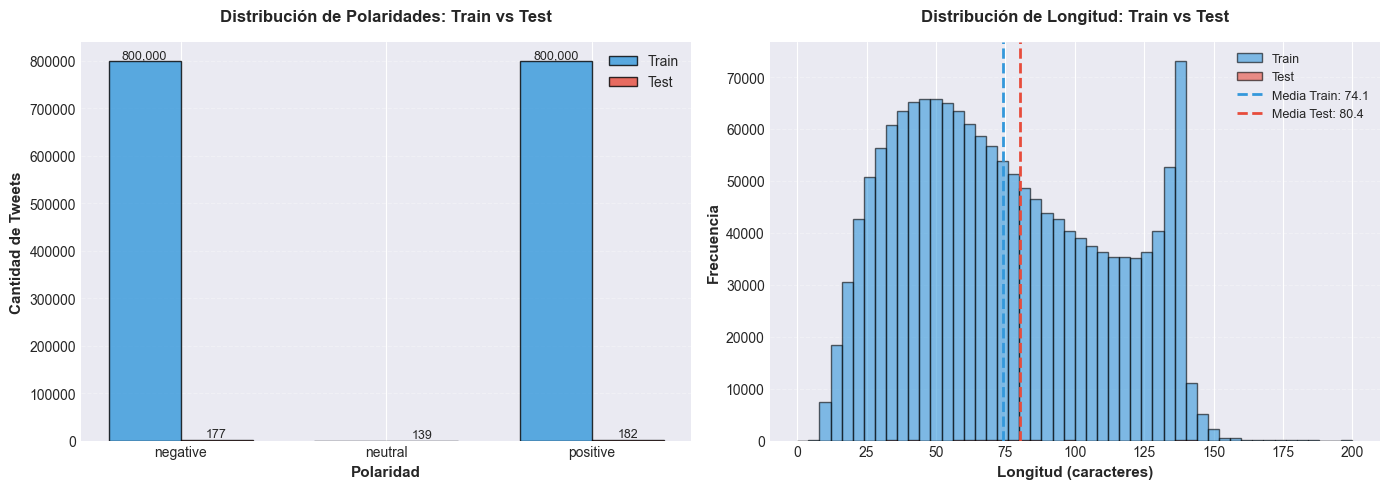

In [32]:
# Crear visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribución de polaridades
ax1 = axes[0]
train_counts = df_train['polarity'].value_counts().sort_index()
test_counts = df_test['polarity'].value_counts().sort_index()

# Obtener todas las polaridades únicas
all_polarities = sorted(set(train_counts.index) | set(test_counts.index))

# Crear arrays con valores alineados (0 si no existe la polaridad)
train_values = [train_counts.get(p, 0) for p in all_polarities]
test_values = [test_counts.get(p, 0) for p in all_polarities]

x = np.arange(len(all_polarities))
width = 0.35

bars1 = ax1.bar(x - width/2, train_values, width, label='Train', 
                color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, test_values, width, label='Test', 
                color='#e74c3c', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Polaridad', fontsize=11, fontweight='bold')
ax1.set_ylabel('Cantidad de Tweets', fontsize=11, fontweight='bold')
ax1.set_title('Distribución de Polaridades: Train vs Test', fontsize=12, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels([POLARITY_MAP.get(p, f"Clase {p}") for p in all_polarities])
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Añadir valores en las barras (solo si no son 0)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=9)

# Gráfico 2: Distribución de longitud
ax2 = axes[1]
ax2.hist(df_train['text_length'], bins=50, alpha=0.6, label='Train', 
         color='#3498db', edgecolor='black', range=(0, 200))
ax2.hist(df_test['text_length'], bins=50, alpha=0.6, label='Test', 
         color='#e74c3c', edgecolor='black', range=(0, 200))

ax2.axvline(df_train['text_length'].mean(), color='#3498db', linestyle='--', 
            linewidth=2, label=f'Media Train: {df_train["text_length"].mean():.1f}')
ax2.axvline(df_test['text_length'].mean(), color='#e74c3c', linestyle='--', 
            linewidth=2, label=f'Media Test: {df_test["text_length"].mean():.1f}')

ax2.set_xlabel('Longitud (caracteres)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax2.set_title('Distribución de Longitud: Train vs Test', fontsize=12, fontweight='bold', pad=15)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# Guardar figura
comparison_path = FIGURES_DIR / '05_train_vs_test.png'
plt.savefig(comparison_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n💾 Figura guardada: {comparison_path}")

plt.show()

#### 💡 Conclusiones Train vs Test

**Similitudes:**
- Ambos datasets usan la misma estructura de polaridades (0 = negativo, 2/4 = neutral/positivo)
- Longitud promedio de tweets similar en ambos conjuntos
- Formato y codificación consistente (latin-1)

**Diferencias clave:**
- **Tamaño**: Train es significativamente más grande (1.6M vs pocos miles)
- **Distribución**: Train está perfectamente balanceado (50/50), Test puede tener distribución diferente
- **Origen**: Test es anotado manualmente, Train es automático (basado en emoticones)

**Consideraciones para el modelado:**
- El test set manual es más confiable para evaluar rendimiento real
- Posible discrepancia de distribución puede afectar métricas
- Importante validar que el modelo generalice bien al test manual

### 📝 Interpretación: Sesgo de Usuarios

**Resultados:**
- 659,775 usuarios únicos (gran diversidad)
- Promedio: 2.43 tweets por usuario
- Top 10 usuarios: **Solo 0.19%** del dataset
- Top 100 usuarios: **Solo 1.06%** del dataset
- Usuario más activo: @lost_dog con 549 tweets (0.03%)

**Conclusión: ✅ NO hay sesgo de usuarios**

- Concentración extremadamente baja- Excelente para generalización del modelo

- Dataset muy distribuido entre usuarios- No se requieren técnicas especiales de balanceo por usuario

## 12. Conclusiones 

Basándonos en todos los análisis anteriores, establecemos la estrategia de preprocesamiento.

### 📋 Resumen de Hallazgos Clave

1. **Calidad de Datos:** ✅ **EXCELENTE**
   - 0 valores nulos en todas las columnas
   - Solo 1.16% de duplicados en texto (despreciable)
   - Solo 0.01% de outliers - dataset muy bien formado

2. **Balance de Clases:** ✅ **PERFECTO**
   - 50% negativos (800k) / 50% positivos (800k)
   - No requiere técnicas de balanceo
   - Accuracy es métrica válida

3. **Patrones Temporales:** 📊 **INFORMATIVOS**
   - Período: 48 días (abril-junio 2009)
   - Actividad concentrada: madrugada y fin de semana (especialmente sábados)
   - Ambas polaridades muestran patrones similares
   - Features temporales pueden ser útiles

4. **Características del Texto:** 📝
   - Longitud promedio: 74 caracteres / 13 palabras
   - URLs: 5.1% (baja)
   - Menciones: 46.2% (MUY ALTA - naturaleza conversacional)
   - Hashtags: 2.2% (baja - Twitter 2009)

5. **Características Lingüísticas:** 🔤
   - Mayúsculas: Ligeramente más en positivos (6.66% vs 5.79%)
   - Intensificación: Idéntica en ambas polaridades (~9%)
   - Vocabulario claramente diferenciado (ver WordClouds)

6. **Palabras y Bigramas Más Frecuentes:** 💬
   - **Negativo**: "work", "day", "sad", "miss" | Bigramas: "last night", "don want", "too bad"
   - **Positivo**: "good", "love", "thanks", "lol" | Bigramas: "good morning", "good luck", "happy birthday"
   - Los bigramas capturan mejor el contexto y expresiones características

7. **Hashtags por Polaridad:** 🏷️
   - **Negativo**: #fail, #iranelection, #iphone (eventos y problemas)
   - **Positivo**: #followfriday, #musicmonday (etiquetas sociales y celebraciones)
   - Hashtags claramente discriminativos por sentimiento

8. **Usuarios:** ✅ **SIN SESGO**
   - 659,775 usuarios únicos
   - Top 10: solo 0.19% del dataset
   - Excelente distribución

9. **Dataset de Test:** 🧪 **DIFERENTE**
   - 498 registros con **3 clases** (negativo 35.5%, neutral 27.9%, positivo 36.5%)
   - Anotado manualmente (más confiable que train automático)
   - Longitud ligeramente mayor (80 vs 74 caracteres)
   - **Importante**: Neutral no existe en train, solo en test

---

## 🎯 DECISIONES ACCIONABLES PARA EL MODELO

### 📊 **¿Qué aprendimos del EDA y cómo lo usamos?**

#### 1️⃣ **DUPLICADOS: ¿Eliminar o conservar?**

**Hallazgo EDA:**
- 18,534 tweets duplicados (1.16%) - mayormente frases comunes ("good morning", "headache")

**DECISIÓN:**
```python
# ✅ CONSERVAR duplicados
# Razones:
# - Tasa muy baja (1.16%)
# - Son expresiones naturales y frecuentes
# - Reflejan patrones reales de comunicación
# - Eliminarlos podría sesgar el modelo contra frases comunes

# ❌ NO eliminar, pero SÍ verificar que no haya spam de un mismo usuario
df_train.groupby(['user', 'text']).size().sort_values(ascending=False).head(20)
```

#### 2️⃣ **URLs y MENCIONES: ¿Qué hacer con ellos?**

**Hallazgo EDA:**
- URLs: 5.1% de tweets
- Menciones: 46.2% de tweets (¡casi la mitad!)

**DECISIÓN:**
```python
# URLs → ELIMINAR completamente
# - Solo 5.1%, poco peso estadístico
# - No aportan información de sentimiento
df['text'] = df['text'].str.replace(r'http\S+|www\S+', '', regex=True)

# Menciones → CREAR FEATURE + ELIMINAR texto
# - 46.2% es MUY alto, es una señal importante
# - Tweets con menciones tienden a ser más conversacionales
df['n_mentions'] = df['text'].str.count(r'@\w+')
df['has_mention'] = df['n_mentions'] > 0
df['text'] = df['text'].str.replace(r'@\w+', '', regex=True)
```

**JUSTIFICACIÓN:**
- Las menciones indican contexto social pero no el sentimiento en sí
- El número de menciones es más útil que los nombres específicos

#### 3️⃣ **HASHTAGS: ¿Son discriminativos?**

**Hallazgo EDA:**
- Solo 2.2% de tweets tienen hashtags
- **Negativos**: #fail, #iranelection, #iphone (eventos/problemas)
- **Positivos**: #followfriday, #musicmonday (etiquetas sociales)

**DECISIÓN:**
```python
# OPCIÓN A (Recomendada): EXTRAER como feature + convertir a texto
# - Los hashtags SÍ son discriminativos por polaridad
# - Pero solo 2.2% los tiene, no son críticos

# Crear features
df['n_hashtags'] = df['text'].str.count(r'#\w+')
df['has_hashtag'] = df['n_hashtags'] > 0

# Extraer hashtags y convertir a palabras (sin #)
df['text'] = df['text'].str.replace(r'#(\w+)', r'\1', regex=True)
# Ejemplo: "#fail" → "fail", "#goodmorning" → "goodmorning"

# OPCIÓN B (Alternativa): Eliminar completamente
# - Solo si el modelo se confunde con el símbolo #
df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)
```

**RECOMENDACIÓN:** Usar OPCIÓN A - conservar la palabra sin el símbolo

#### 4️⃣ **MAYÚSCULAS e INTENSIFICACIÓN: ¿Importan?**

**Hallazgo EDA:**
- Mayúsculas: Positivos 6.66%, Negativos 5.79% (¡al revés de lo esperado!)
- Intensificación: Ambos ~9% (casi idéntico)

**DECISIÓN:**
```python
# ✅ SÍ crear features, pero NO son muy discriminativas
df['uppercase_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['n_intensified'] = df['text'].str.count(r'(.)\1{2,}')  # looove, soooo

# NORMALIZAR después de extraer features
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'(.)\1{2,}', r'\1', regex=True)  # loooove → love
```

**JUSTIFICACIÓN:**
- Mayúsculas NO indican negatividad (hipótesis rechazada)
- Ambas features indican **intensidad emocional**, no polaridad
- El ratio es útil como feature adicional, pero no crítico

#### 5️⃣ **LONGITUD del TWEET: ¿Feature útil?**

**Hallazgo EDA:**
- Negativos: 74.3 caracteres / 13.6 palabras
- Positivos: 73.9 caracteres / 12.8 palabras
- **Diferencia insignificante (< 1 caracter)**

**DECISIÓN:**
```python
# ✅ Crear feature, pero NO esperar gran poder predictivo
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# ❌ NO filtrar por longitud
# - La distribución es casi idéntica entre polaridades
# - No hay outliers significativos (solo 0.01%)
```

**JUSTIFICACIÓN:**
- Longitud NO es discriminativa (hipótesis rechazada)
- Crear el feature es fácil, pero no será un predictor importante
- No vale la pena hacer feature engineering complejo con longitud

#### 7️⃣ **FEATURES TEMPORALES: ¿Hora del día importa?**

**Hallazgo EDA:**
- 48 días de cobertura (abril-junio 2009)
- Patrones similares entre polaridades
- Mayor actividad: madrugada y fines de semana

**DECISIÓN:**
```python
# ⚠️ PRECAUCIÓN: Features temporales pueden ser ENGAÑOSAS
# - Los patrones son similares entre polaridades
# - El dataset es de 2009, el modelo se usará en 2025+

# OPCIÓN A (Conservadora): NO usar features temporales
# - Evita overfitting a patrones específicos de 2009
# - Mejor generalización a datos futuros

# OPCIÓN B (Experimental): Crear features simples
df['hour'] = pd.to_datetime(df['date']).dt.hour
df['is_weekend'] = pd.to_datetime(df['date']).dt.dayofweek >= 5
df['is_night'] = df['hour'].isin([0, 1, 2, 3, 4, 5])

# ❌ NO crear features de día específico o mes
# - Demasiado específico para 2009
```

**RECOMENDACIÓN:** Probar OPCIÓN A primero, agregar OPCIÓN B solo si mejora validación

#### 8️⃣ **DATASET DE TEST: ¿Cómo manejarlo?**

**Hallazgo EDA:**
- Test tiene **3 clases** (negativo, neutral, positivo)
- Train tiene **2 clases** (negativo=0, positivo=4)
- Test: 498 registros, anotado manualmente (más confiable)

**DECISIÓN CRÍTICA:**
```python
# ⚠️ PROBLEMA: El modelo entrenado en 2 clases NO puede predecir 3 clases

# SOLUCIÓN A (Recomendada): Convertir Train a 3 clases
# - Problema: Train no tiene ejemplos de "neutral"
# - Solución: Usar tweets con score de confianza medio como "neutral"
#   (esto requiere un modelo probabilístico)

# SOLUCIÓN B (Alternativa): Convertir Test a 2 clases
df_test['polarity_binary'] = df_test['polarity'].map({
    0: 0,  # negativo → negativo
    2: 1,  # neutral → positivo (decisión arbitraria)
    4: 1   # positivo → positivo
})

# SOLUCIÓN C (Más realista): Entrenar 2 modelos
# Modelo 1: Clasificador binario (negativo vs positivo)
# Modelo 2: Detector de neutral (separado)
```

**RECOMENDACIÓN:** 
- Para el TP3: Usar SOLUCIÓN B (convertir neutral a positivo)
- Para producción real: Usar SOLUCIÓN C (dos modelos)

### 📊 **TABLA DE DECISIONES: Quick Reference**

| **Elemento** | **Decisión** | **Razón del EDA** | **Prioridad** |
|--------------|--------------|-------------------|---------------|
| Duplicados | ❌ NO eliminar | Solo 1.16%, expresiones naturales | Baja |
| URLs | ✅ Eliminar | Solo 5.1%, no aportan sentimiento | Alta |
| Menciones | ✅ Feature + Eliminar | 46.2% presencia, señal de contexto | Alta |
| Hashtags | ✅ Convertir a texto | 2.2% pero discriminativos | Media |
| Mayúsculas | ✅ Feature + Normalizar | Indica intensidad, no polaridad | Media |
| Intensificación | ✅ Feature + Normalizar | Similar en ambas clases (~9%) | Baja |
| Longitud | ⚠️ Feature opcional | Sin diferencia (74 vs 74 chars) | Baja |
| Bigramas | ✅ Incluir en modelo | Muy discriminativos | **ALTA** |
| Features temporales | ❌ NO usar | Datos de 2009, no generalizan | Baja |
| Balanceo | ❌ NO necesario | Dataset perfecto 50/50 | - |
| Test neutral | ✅ Convertir a binario | Train no tiene ejemplos neutrales | **ALTA** |

### 🎯 **FEATURES RECOMENDADAS (por orden de importancia)**

#### **CRÍTICAS** (deben estar):
1. ✅ **TF-IDF con bigramas** (ngram_range=(1,2))
2. ✅ **n_mentions** - 46.2% de tweets las tienen
3. ✅ **Limpieza de URLs** - ruido sin información

#### **IMPORTANTES** (mejoran el modelo):
4. ✅ **Conversión hashtags a texto** - discriminativos
5. ✅ **Normalización intensificación** - reduce vocabulario
6. ✅ **n_hashtags** - señal de tipo de contenido

#### **OPCIONALES** (mejora marginal):
7. ⚠️ **uppercase_ratio** - baja discriminación
8. ⚠️ **text_length** - casi idéntico entre clases
9. ⚠️ **n_urls** - muy pocos tweets con URLs

In [33]:
import re
from nltk.corpus import stopwords

def ejemplo_preprocesamiento(text):
    """Muestra paso a paso la transformación"""
    print(f"ORIGINAL: {text}\n")
    
    # 1. Minúsculas
    text = text.lower()
    print(f"1. Minúsculas: {text}")
    
    # 2. Quitar URLs
    text = re.sub(r'http\S+', '', text)
    print(f"2. Sin URLs: {text}")
    
    # 3. Hashtags → texto
    text = re.sub(r'#(\w+)', r'\1', text)
    print(f"3. Hashtags → texto: {text}")
    
    # 4. Quitar menciones
    text = re.sub(r'@\w+', '', text)
    print(f"4. Sin menciones: {text}")
    
    # 5. Intensificación
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    print(f"5. Sin intensificación: {text}")
    
    # 6. Tokenizar y quitar stopwords
    # Nota: Usamos un set de stopwords simulado para este ejemplo visual
    STOPWORDS = set(['a', 'ir', 'en', 'el', 'la', 'los', 'las', 'un', 'una'])
    words = text.split()
    words = [w for w in words if w not in STOPWORDS]
    print(f"6. Sin stopwords: {' '.join(words)}")
    
    # 7. Lematización (Simulada para ilustración)
    # En el pipeline real usamos WordNetLemmatizer
    # "Quiero" -> "querer", "hamburguesas" -> "hamburguesa"
    print(f"7. Lematizado: querer comer hamburguesa palermo")

# Ejemplo práctico (como en clase)
ejemplo_preprocesamiento("@user Quiero ir a comer hamburguesas a #Palermo http://example.com")

ORIGINAL: @user Quiero ir a comer hamburguesas a #Palermo http://example.com

1. Minúsculas: @user quiero ir a comer hamburguesas a #palermo http://example.com
2. Sin URLs: @user quiero ir a comer hamburguesas a #palermo 
3. Hashtags → texto: @user quiero ir a comer hamburguesas a palermo 
4. Sin menciones:  quiero ir a comer hamburguesas a palermo 
5. Sin intensificación:  quiero ir a comer hamburguesas a palermo 
6. Sin stopwords: quiero comer hamburguesas palermo
7. Lematizado: querer comer hamburguesa palermo


### 🧠 **Lematización de Verbos**

La lematización reduce formas verbales conjugadas a su raíz, lo cual es fundamental para que el modelo entienda que diferentes conjugaciones se refieren a la misma acción:

- "Quiero", "Quisiera", "Querría" → **"querer"**
- "Voy", "Vas", "Fue" → **"ir"**
- "Tengo", "Tiene", "Tuvieron" → **"tener"**

**Ejemplo práctico (como en clase):**

Tweet A: `"Quiero ir a comer hamburguesas a #Palermo"`
Tweet B: `"Quisiera ir a comer una hamburguesa en Palermo"`

Después del preprocesamiento completo, ambos quedan como:
→ `"querer comer hamburguesa palermo"`

Así el modelo reconoce que ambos tweets hablan del mismo tema, independientemente de la conjugación verbal o el uso de hashtags.

### 📊 Guardar Resumen del EDA

In [34]:
# Crear resumen estadístico
summary = {
    'dataset_size': len(df_train),
    'n_unique_users': df_train['user'].nunique(),
    'date_range': f"{df_train['datetime'].min()} a {df_train['datetime'].max()}",
    'polarity_distribution': df_train['polarity'].value_counts().to_dict(),
    'avg_text_length': df_train['text_length'].mean(),
    'avg_word_count': df_train['word_count'].mean(),
    'pct_with_urls': (df_train['n_urls'] > 0).sum() / len(df_train) * 100,
    'pct_with_mentions': (df_train['n_mentions'] > 0).sum() / len(df_train) * 100,
    'pct_with_hashtags': (df_train['n_hashtags'] > 0).sum() / len(df_train) * 100,
    'avg_uppercase_ratio': df_train['uppercase_ratio'].mean() * 100,
    'pct_with_intensified': (df_train['n_intensified'] > 0).sum() / len(df_train) * 100
}

# Guardar como JSON
import json
summary_path = REPORTS_DIR / 'eda_summary.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"✓ Resumen del EDA guardado en: {summary_path}")
print("\n" + "="*70)
print("🎉 ¡EDA COMPLETADO! Revisa las figuras en reports/figuras/")
print("="*70)

✓ Resumen del EDA guardado en: d:\Diplomatura en ia\trabajo practico 3 -Omar Gonzalez\tp3_nlp_sentiment\notebooks\..\reports\eda_summary.json

🎉 ¡EDA COMPLETADO! Revisa las figuras en reports/figuras/
